In [1]:
import datetime as dt
import itertools as it
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from recsys4daos.utils import notebooks as nbutils
from recsys4daos.model_selection import cvtt_open
import paths

sns.set_theme(rc = {
})
sns.set_context("paper")

# Paper column width in inches
PAPER_COL_WIDTH = 3.5

original = plt.rcParamsDefault['figure.figsize']
ratio = original[0] / original[1]
print(f"Original size: {original}, Ratio: {ratio}")
plt.rcParams['figure.figsize'] = (PAPER_COL_WIDTH, PAPER_COL_WIDTH/ratio)
print("New size:", plt.rcParams['figure.figsize'])

# In acmart, 9pt is the default
# And 7pt for \footnotesize
# plt.rcParams['font.size'] = 7,

# The following are already relatively defined
# plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']

Original size: [6.4, 4.8], Ratio: 1.3333333333333335
New size: [3.5, 2.6249999999999996]


/home/daviddavo/recsys4daos/src/recsys4daos/model_selection.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ORG_NAME = 'Decentraland'
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_FOLDS: int = 10
LAST_FOLD_DATE_STR: str = None # Used just for plotting

# Plotting hparams
RECTANGLE_ALPHA = 0.3

In [3]:
# Parameters
EXECUTION_ID = "2024-09-24T10:00"
MIN_BATCH_SIZE = 4
ORG_NAME = "Aura Finance"
SPLITS_FREQ = "7d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-07-14"


In [4]:
LAST_FOLD_DATE: dt.datetime = dt.datetime.fromisoformat(LAST_FOLD_DATE_STR) if LAST_FOLD_DATE_STR else dt.datetime.now()

In [5]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 415 non-null    object        
 1   author             415 non-null    object        
 2   date               415 non-null    datetime64[us]
 3   start              415 non-null    datetime64[us]
 4   end                415 non-null    datetime64[us]
 5   platform_proposal  415 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 19.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7677 entries, 0 to 7676
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        7677 non-null   object        
 1   proposal  7677 non-null   object        
 2   voter     7677 non-null   object        
 3   date      7677 non-null   datetime64[us]
dtypes: d

In [6]:
print("First vote:", first_vote := dfv['date'].min())
print("Last vote:", last_vote := dfv['date'].max())
paths.save_dao_datum(ORG_NAME, 'dfv_first_vote', str(first_vote))
paths.save_dao_datum(ORG_NAME, 'dfv_last_vote', str(last_vote))

First vote: 2022-06-17 09:57:28
Last vote: 2023-07-16 22:24:26


In [7]:
folds = list(cvtt_open(dfv, SPLITS_FREQ, dfp, normalize=SPLITS_NORMALIZE, col_item='proposal', col_time='date', last_fold=LAST_FOLD_DATE_STR))[-LAST_FOLDS:]
print(f"Using {len(folds)} folds from {folds[0].end} to {folds[-1].end}")
paths.save_dao_datum(ORG_NAME, 'first_fold_date', str(folds[0].end))

Using 10 folds from 2023-05-12 00:00:00 to 2023-07-14 00:00:00


## Proposals and time

### How much time does each proposal take

3 days 08:00:00    344
3 days 00:00:00     45
5 days 00:00:00     12
2 days 00:00:00      2
4 days 21:00:00      1
2 days 23:56:45      1
3 days 06:30:00      1
4 days 18:00:00      1
4 days 08:59:51      1
2 days 08:00:00      1
3 days 08:20:06      1
3 days 07:07:12      1
3 days 07:04:17      1
2 days 23:57:23      1
0 days 23:59:23      1
3 days 07:35:09      1
Name: count, dtype: int64
3 days 08:00:00    0.828916
3 days 00:00:00    0.108434
5 days 00:00:00    0.028916
2 days 00:00:00    0.004819
4 days 21:00:00    0.002410
2 days 23:56:45    0.002410
3 days 06:30:00    0.002410
4 days 18:00:00    0.002410
4 days 08:59:51    0.002410
2 days 08:00:00    0.002410
3 days 08:20:06    0.002410
3 days 07:07:12    0.002410
3 days 07:04:17    0.002410
2 days 23:57:23    0.002410
0 days 23:59:23    0.002410
3 days 07:35:09    0.002410
Name: count, dtype: float64


count                       415
mean     3 days 08:07:35.436144
std      0 days 08:40:11.097019
min             0 days 23:59:23
25%             3 days 08:00:00
50%             3 days 08:00:00
75%             3 days 08:00:00
max             5 days 00:00:00
dtype: object

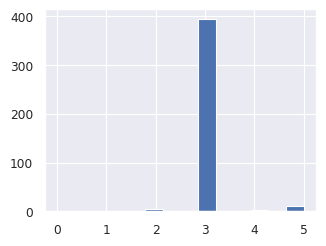

In [8]:
# Original: Cell [5] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb

delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
print(vc := delta.value_counts())
print(vc / len(delta))
paths.save_dao_datum(ORG_NAME, 'median_open_time', str(delta.median()))
delta.describe()

#### Avg. proposal length in time

In [9]:
def add_folds_to_plot(fig=plt, cont=True):

    if cont:
        start_date = folds[0].end
        end_date = folds[-1].end
        fig.axvspan(start_date, end_date, color='C2', alpha=RECTANGLE_ALPHA)
    else:
        for fprev, f, c in zip(folds, folds[1:], it.cycle([0,1])):
            start_date = fprev.end
            end_date = f.end
            fig.axvspan(start_date, end_date, alpha=RECTANGLE_ALPHA, color='C1' if c else 'C2')

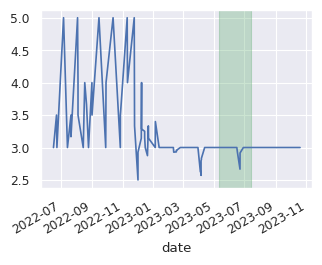

In [10]:
# Original: Cell [6] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb
ROLLING_LENGTH = '7d'

_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling(ROLLING_LENGTH).mean().plot()

add_folds_to_plot()

## How many proposals are created per week

26.0
2023-02-17 11:24:54


<Figure size 350x262.5 with 0 Axes>

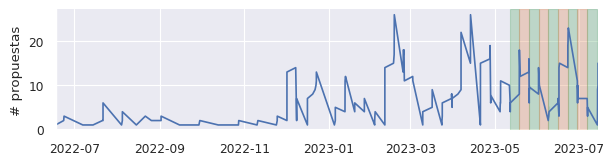

In [11]:
WINDOW_SIZE = '7d' # dt.timedelta(days=7)

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()
print(max_cnt := _toplot['cnt'].max())
print(max_date := _toplot[_toplot['cnt'] == max_cnt].iloc[0]['date'])
paths.save_dao_datum(ORG_NAME, 'max_proposals_ws', WINDOW_SIZE)
paths.save_dao_datum(ORG_NAME, 'max_proposals_cnt', int(max_cnt))
paths.save_dao_datum(ORG_NAME, 'max_proposals_date', str(max_date))

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=fs * (2,.6))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)
add_folds_to_plot(cont=False)

sns.despine()

<Figure size 350x262.5 with 0 Axes>

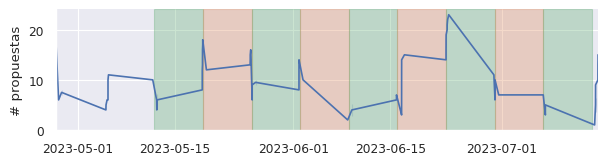

In [12]:
_toplot = _toplot[_toplot['date'] > (folds[0].end - pd.tseries.frequencies.to_offset(SPLITS_FREQ)*3)]
_toplot = _toplot[_toplot['date'] < (folds[-1].end + pd.tseries.frequencies.to_offset(SPLITS_FREQ)*3)]
fs = plt.gcf().get_size_inches()
plt.figure(figsize=fs * (2,.6))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)
add_folds_to_plot(cont=False)

sns.despine()

## Queue size (open proposals)

15
2023-04-20 12:00:00


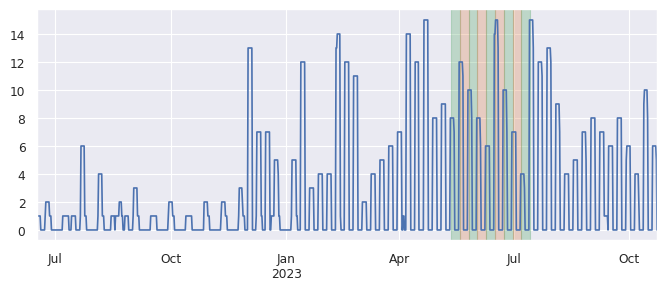

In [13]:
# This will be the "resolution" of the graph
_GROUPER_FREQ = '12h'

df_events = pd.concat((
    dfp.groupby('start').size(),
    -dfp.groupby('end').size(),
)).sort_index()
qsize = df_events.groupby(pd.Grouper(freq=_GROUPER_FREQ)).sum().cumsum()

print(max_qsize := qsize.max())
print(max_date := qsize[qsize == max_qsize].index[0])
paths.save_dao_datum(ORG_NAME, 'max_open_freq', _GROUPER_FREQ)
paths.save_dao_datum(ORG_NAME, 'max_open_cnt', int(max_qsize))
paths.save_dao_datum(ORG_NAME, 'max_open_date', str(max_date))

qsize.plot(figsize=(8,3))
add_folds_to_plot(cont=False)

15
2023-06-16 12:00:00


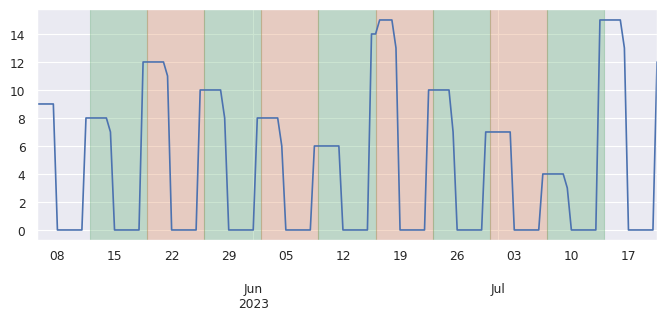

In [14]:
_toplot = qsize[qsize.index > (folds[0].end - pd.tseries.frequencies.to_offset(SPLITS_FREQ)*1)]
_toplot = _toplot[_toplot.index < (folds[-1].end + pd.tseries.frequencies.to_offset(SPLITS_FREQ)*1)]

print(max_qsize := _toplot.max())
print(max_date := _toplot[_toplot == max_qsize].index[0])
paths.save_dao_datum(ORG_NAME, 'max_open_freq_test', _GROUPER_FREQ)
paths.save_dao_datum(ORG_NAME, 'max_open_cnt_test', int(max_qsize))
paths.save_dao_datum(ORG_NAME, 'max_open_date_test', str(max_date))

_toplot.plot(figsize=(8,3))
add_folds_to_plot(cont=False)

## What day of the week are proposals created

start
Thursday    406
Friday        4
Sunday        2
Tuesday       2
Monday        1
Name: count, dtype: int64


/tmp/ipykernel_1809020/3307774390.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')


Cannot show ipywidgets in text

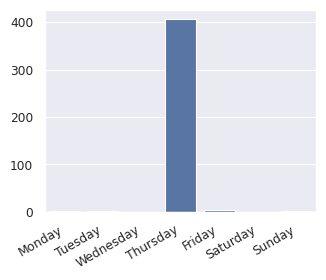

In [15]:
# Original: Cell [7] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb
DAYS_OF_WEEK_ENG = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=DAYS_OF_WEEK_ENG)
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
print(dfp['start'].dt.day_name().value_counts())
ax.set_xlabel('')
ax.set_ylabel('# proposals')
ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')

# Updates
ax.set_ylabel('')

nbutils.download_matplotlib(ax.figure, 'proposals_dow.pdf')

## What day of the week are proposals voted

date
Friday       2354
Saturday     1390
Sunday       1332
Monday       1314
Thursday     1012
Tuesday       219
Wednesday      56
Name: count, dtype: int64


/tmp/ipykernel_1809020/3643726510.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')


Cannot show ipywidgets in text

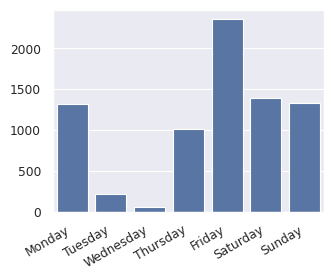

In [16]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=DAYS_OF_WEEK_ENG)
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
print(dfv['date'].dt.day_name().value_counts())
ax.set_xlabel('')
ax.set_ylabel('# votes')
ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')

# Updates
ax.set_ylabel('')

nbutils.download_matplotlib(ax.figure, "votes_dow.pdf")

## In which moment of the proposal lifetime are votes cast

time remaining                                          \
                         count      mean       std       min       25%   
delta                                                                    
0 days 23:59:23           98.0  0.750800  0.279143  0.035756  0.658152   
2 days 00:00:00           43.0  0.532592  0.319474  0.065642  0.241904   
2 days 08:00:00           59.0  0.658205  0.267947  0.022247  0.537550   
2 days 23:56:45           55.0  0.705205  0.278715  0.058370  0.620191   
2 days 23:57:23           16.0  0.614840  0.290326  0.007551  0.415601   
3 days 00:00:00         1048.0  0.630328  0.298283  0.001593  0.391766   
3 days 06:30:00           68.0  0.685832  0.278499  0.020899  0.545535   
3 days 07:04:17           26.0  0.635916  0.281109  0.064175  0.463863   
3 days 07:07:12           19.0  0.642096  0.266673  0.064017  0.463668   
3 days 08:00:00         3169.0  0.566613  0.290315  0.000705  0.361764   
3 days 08:20:06           25.0  0.423333  0.250644  0.037212  0.247191   
4 days 08:59:51          220.0  0.427980  0.330205  0.001138  0.113779   
4 days 18:00:00          171.0  0.350786  0.331096  0.000902  0.081665   
4 days 21:00:00          101.0  0.665396  0.309546  0.000100  0.442434   
5 days 00:00:00         2559.0  0.390478  0.314616  0.000081  0.094270   

                                               
                      50%       75%       max  
delta                                          
0 days 23:59:23  0.876209  0.955189  0.996098  
2 days 00:00:00  0.458235  0.860955  0.999664  
2 days 08:00:00  0.671572  0.861354  0.995278  
2 days 23:56:45  0.727102  0.933546  0.998606  
2 days 23:57:23  0.607793  0.851447  0.980077  
3 days 00:00:00  0.722676  0.877908  0.999703  
3 days 06:30:00  0.727015  0.934513  0.986047  
3 days 07:04:17  0.702793  0.868056  0.988126  
3 days 07:07:12  0.715703  0.866135  0.987628  
3 days 08:00:00  0.627753  0.802135  0.999944  
3 days 08:20:06  0.416312  0.591053  0.808427  
4 days 08:59:51  0.350429  0.747897  0.999656  
4 days 18:00:00  0.196145  0.697463  0.998901  
4 days 21:00:00  0.779174  0.906064  0.977134  
5 days 00:00:00  0.293806  0.695983  0.999299

1317 (17.16%) of the votes are being cast on the first 14.29% of rel time
6079 (79.18%) of the votes are being cast on the first 85.71% of rel time


Cannot show ipywidgets in text

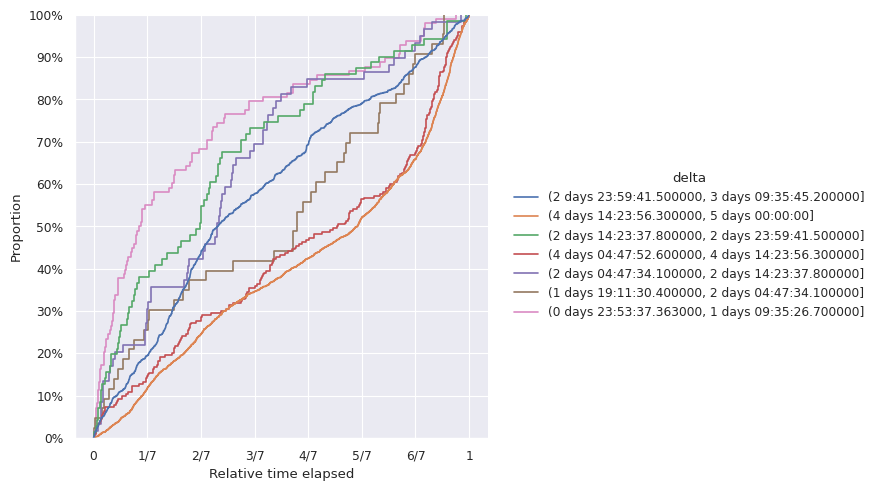

In [17]:
from matplotlib import ticker

PLOT_HUE = True
BINS = 10

_dfv = dfv[['proposal', 'date']].merge(dfp[['id', 'start', 'end']], left_on='proposal', right_on='id').sort_values('date')
if not all(_dfv['date'] >= _dfv['start']):
    warnings.warn('There cant be votes before the proposal started')
if not all(_dfv['end'] >= _dfv['date']):
    warnings.warn('There cant be votes after the proposal ended')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
_dfv['delta'] = (_dfv['end'] - _dfv['start'])
_dfv['time remaining'] = 1 - _dfv['date_rel']

display(_dfv.groupby('delta')[['time remaining']].describe())

for t in [1/7, 6/7]:
    first_day = (_dfv['date_rel'] < t)
    print(f"{first_day.sum()} ({first_day.mean()*100:.2f}%) of the votes are being cast on the first {t*100:.2f}% of rel time")

if len(_dfv['delta'].value_counts()) > BINS:
    _dfv['delta_original'] = _dfv['delta']
    _dfv['delta'] = pd.cut(_dfv['delta'], BINS)

_dfv['delta'] = _dfv['delta'].astype(str)
fg = sns.displot(_dfv, x='date_rel', kind='ecdf', hue='delta' if PLOT_HUE else None)
# fg.ax.xaxis.set_major_locator(ticker.MultipleLocator(1/7))

fg.ax.yaxis.set_major_locator(ticker.MultipleLocator(1/10))
fg.ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
fg.ax.set_xticks(np.arange(8)/7)
fg.ax.set_xticklabels(["0"] + [f"{x}/7" for x in range(1,7)] + ["1"])
fg.ax.set_xlabel('Relative time elapsed');

nbutils.download_matplotlib(fg, f"votes_in_time{'-color' if PLOT_HUE else ''}.pdf")

## Explore folds

### Just the folds that are used

In [18]:
from collections import defaultdict

foldsinfo = defaultdict(list)
for f in folds:
    # print(len(f.open_proposals), "open proposals")
    foldsinfo['t'].append(f.end)
    foldsinfo['open proposals'].append(len(f.open_proposals))
    foldsinfo['users in train'].append(f.train['voter'].nunique())
    foldsinfo['users in test'].append(f.test['voter'].nunique())
    foldsinfo['votes in train'].append(len(f.train))
    foldsinfo['votes in test'].append(len(f.test))
    foldsinfo['users in both'].append(len(np.intersect1d(f.test['voter'].unique(), f.test['voter'].unique())))
    # votes per proposal
    foldsinfo['vpp test'].append(f.test.groupby('proposal').size().mean())
    # votes per voter
    foldsinfo['vpv test'].append(f.test.groupby('voter').size().mean())

dff = pd.DataFrame(foldsinfo).set_index('t')
paths.save_dao_datum(ORG_NAME, 'folds_avg_open_proposals', dff['open proposals'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_votes', dff['votes in test'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_users', dff['users in test'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_vpp', dff['vpp test'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_vpv', dff['vpv test'].mean())
dff

,open proposals,users in train,users in test,votes in train,votes in test,users in both,vpp test,vpv test
t,,,,,,,,
2023-05-12,8,664,23,7022,61,23,7.625000,2.652174
2023-05-19,12,671,12,7110,61,12,5.083333,5.083333
2023-05-26,10,671,13,7175,53,13,5.300000,4.076923
2023-06-02,8,671,17,7235,56,17,7.000000,3.294118
2023-06-09,6,674,12,7293,43,12,7.166667,3.583333
2023-06-16,14,674,13,7339,81,13,5.785714,6.230769
2023-06-23,10,676,12,7428,82,12,8.200000,6.833333
2023-06-30,7,677,12,7511,54,12,7.714286,4.500000
2023-07-07,4,678,17,7565,37,17,9.250000,2.176471


## Histograms

### Votes per user

count    678.000000
mean      11.323009
std       19.911409
min        1.000000
10%        1.000000
15%        1.000000
50%        5.000000
90%       23.900000
95%       47.000000
99%      103.680000
max      180.000000
dtype: float64
200 voters (29.50%) have voted more than 10 times
7 voters (1.03%) have voted more than 100 times


Cannot show ipywidgets in text

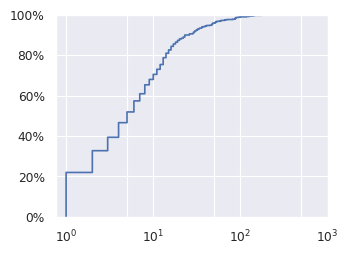

In [19]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print(_toplot.describe(percentiles=[.1, .15, .5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votes')
plt.ylabel('% voters')

_times_voted = [10, 100]
for t in _times_voted:
    _nusers = (_toplot > t).sum()
    print(f"{_nusers} voters ({_nusers/len(_toplot)*100:.2f}%) have voted more than {t} times")

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

# Updates by Javi
plt.xlabel("")
plt.ylabel("")

nbutils.download_matplotlib(ax.figure, "ecdf-vpv.pdf")

### Votes per proposal

count    309.000000
mean      24.844660
std       43.328125
min        2.000000
10%        5.000000
15%        6.000000
20%        7.000000
25%        8.000000
50%       11.000000
75%       21.000000
90%       45.000000
95%       86.000000
99%      241.480000
max      248.000000
dtype: float64
Total votes: 7677
174 proposals (56.31%) have more than 10 votes
16 proposals (5.18%) have more than 72 votes
16 proposals (5.18%) have more than 73 votes
15 proposals (4.85%) have more than 100 votes


Cannot show ipywidgets in text

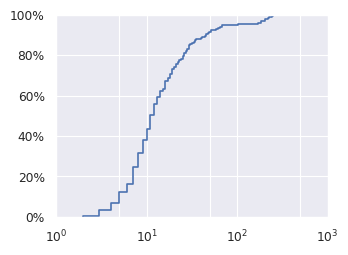

In [20]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.1, .15, .20, .25, .5,.75,.9, .95, .99]))

print("Total votes:", _toplot.sum())
_times_voted = [10, 72, 73, 100]
for t in _times_voted:
    _nprops = (_toplot > t).sum()
    print(f"{_nprops} proposals ({_nprops/len(_toplot)*100:.2f}%) have more than {t} votes")

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

plt.xlabel('# votes')
plt.ylabel('% proposals')

# Updates by Javi
plt.xlabel("")
plt.ylabel("")

nbutils.download_matplotlib(ax.figure, "ecdf-vpp.pdf")